In [65]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.io as scio
from PIL import Image
import os
from IPython.display import display
import re
import tensorflow as tf

In [66]:
from PIL import Image
import os
from IPython.display import display


input_dir = '/kaggle/input/miml-image-data/original/original'   
output_dir = '/kaggle/working/'  


os.makedirs(output_dir, exist_ok=True)


new_width = 128
new_height = 128


# def resize_image(input_path, output_path, new_width, new_height):
#     image = Image.open(input_path)
#     resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
#     resized_image.save(output_path)
#     return resized_image

def resize_image(input_path, new_width, new_height):
    image = Image.open(input_path)
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
   
    return np.array(resized_image);

# print(resize_image("/kaggle/input/miml-image-data/miml-image-data/original/1.jpg",new_width,new_height).shape)

# for filename in os.listdir(input_dir):
#     if filename.endswith('.jpg') or filename.endswith('.png'):
#         input_path = os.path.join(input_dir, filename)
#         output_path = os.path.join(output_dir, filename)
#         resized_image = resize_image(input_path, output_path, new_width, new_height)
#         display(resized_image)


In [67]:
import os

image_folder = '/kaggle/input/miml-image-data/original/original'


image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]

test_image_paths=image_paths[1950:]
# sorting the given paths of data
sorted_image_paths = sorted(image_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))





In [68]:
# getting labels from miml-image-data
a=scio.loadmat("/kaggle/input/miml-image-data/miml-image-data/processed/miml data.mat")
a_labels=a["targets"]
a_labels
a_labelstext=a["class_name"]
a_labelstext=[a_labelstext[i][0][0] for i in range(0,5)]
y = a_labels
y = y.transpose()
y = np.array([[elem if elem == 1 else 0 for elem in row]for row in y])

In [69]:
li=a_labelstext
def labelfinder(labels,set_val):
    fa =False;
    for i in range(0,len(labels)):
        if(labels[i]>=set_val):
            fa=True;
            print(f"{li[i]} , ");
    if(fa==False):
        print(a_labelstext[np.argmax(labels)]);

In [70]:
# p=Image.open("/kaggle/input/miml-image-data/miml-image-data/original/1.jpg")
# display(p)
# print(np.array(p).shape)
# p.size

In [71]:
# setting training ,validation,test data
x_train=sorted_image_paths[:1800]
y_train=y[:1800]
x_val=sorted_image_paths[1800:1900]
y_val=y[1800:1900]
x_test=sorted_image_paths[1900:]
y_test=y[1900:]

In [72]:
# from sklearn.model_selection import train_test_split
# x_train,x_val,y_train,y_val=train_test_split(x_array[:num_images],y_array[:num_images],test_size=0.2,random_state=42)
# len(x_train),len(y_train)

In [73]:
# def get_image_label(image_path,label):
#   image=resize_image(image_path,new_width,new_height)
#   return tf.constant(image),label
def resize1_image(image, new_width=128, new_height=128):
    # Resize the image using TensorFlow's operations
    return tf.image.resize(image, (new_width, new_height))

def get_image_label(image_path, label):
    # Load the image using TensorFlow's operations
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming RGB images
    
    # Preprocess the image using the resized_image function
    resized_image = resize1_image(image, new_width, new_height)
    
    return resized_image, label
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def display_image(image_path):
    s="/kaggle/input/miml-image-data/miml-image-data/original/"
    i=int(image_path.split('/')[-1].split(".")[0])
    display(Image.open(f"{s}{i}.jpg"))

    print(a_labelstext[np.argmax(y[i])])
    
    
def predict_outcomes(image_path,model):
    image = tf.io.read_file(image_path);
    image = tf.image.decode_jpeg(image, channels=3);
    t=tf.image.resize(image, (new_width, new_height));
    predicted=model.predict(tf.reshape(t,(-1,128,128,3)));
    
    print(f"predicted labels:: {predicted}");
    labelfinder(predicted[0],0.7);
    print("correct labels");
    display_image(image_path);
def predictimages(image_path,model):
    image = tf.io.read_file(image_path);
    image = tf.image.decode_jpeg(image, channels=3);
    t=tf.image.resize(image, (new_width, new_height));
    predicted=model.predict(tf.reshape(t,(-1,128,128,3)));
    
    print(f"predicted labels:: {predicted}");
    labelfinder(predicted[0],0.7);
    print("correct labels");
    display(Image.open(image_path));   
def testing(image_path):
    image = tf.io.read_file(image_path);
    image = tf.image.decode_jpeg(image, channels=3);
    t=tf.image.resize(image, (new_width, new_height));
    return t;
    
    

In [74]:
BATCH_SIZE=32
def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  if test_data:
    print("creating test data batches")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch=data.map(testing).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("creating validation data batches")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("creating training data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.shuffle(buffer_size=len(x))
    data=data.map(get_image_label)
    data_batch=data.batch(BATCH_SIZE)
    return data_batch


In [75]:
testdata1=create_data_batches(x_test,y_test,valid_data=True)
testdata2=create_data_batches(sorted_image_paths[1650:1950],y[1650:1950],valid_data=True)
trainingdataset=create_data_batches(x_train,y_train)
validationdataset=create_data_batches(x_train,y_train,valid_data=True)

creating validation data batches
creating validation data batches
creating training data
creating validation data batches


In [76]:

# for i in range(1500,1530):
#     s="/kaggle/input/miml-image-data/miml-image-data/original/"
    
#     display(Image.open(f"{s}{i}.jpg"))
#     print(y[i])
#     print(a_labelstext[np.argmax(y[i])][0][0])
#     print(i)
# Image.open("/kaggle/input/miml-image-data/miml-image-data/original/2.jpg")

In [77]:
# model architcture using cnn(convolution nueral network)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape, num_labels):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    output_layer = Dense(num_labels, activation='sigmoid')(x)  
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model

input_shape = (128, 128, 3)  # Assuming 3 channels for RGB images
num_labels = 5


In [78]:
# model compilation
model = create_model(input_shape, num_labels)

model.compile(loss=tf.keras.losses.binary_crossentropy,
            optimizer=tf.keras.optimizers.Adam(lr=0.001),
            metrics=['accuracy',"mse"])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       7385

In [79]:
%load_ext tensorboard
import datetime
def create_tensorboard_callback():
  logdir=os.path.join("/kaggle/working/",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [80]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
tensorboard=create_tensorboard_callback()

In [81]:
num_epochs=10

In [82]:
# model fitting tranig model
model.fit(x=trainingdataset,epochs=num_epochs,validation_data=validationdataset,
        validation_freq=1,
        callbacks=[tensorboard,early_stopping])

Epoch 1/10
57/57 [==============================] - 45s 765ms/step - loss: 8.1713 - accuracy: 0.3428 - mse: 0.2172 - val_loss: 0.5077 - val_accuracy: 0.5139 - val_mse: 0.1676
Epoch 2/10
57/57 [==============================] - 45s 790ms/step - loss: 0.4769 - accuracy: 0.5267 - mse: 0.1515 - val_loss: 0.3510 - val_accuracy: 0.6567 - val_mse: 0.1090
Epoch 3/10
57/57 [==============================] - 45s 787ms/step - loss: 0.3576 - accuracy: 0.6517 - mse: 0.1097 - val_loss: 0.2846 - val_accuracy: 0.6961 - val_mse: 0.0863
Epoch 4/10
57/57 [==============================] - 43s 758ms/step - loss: 0.2838 - accuracy: 0.6867 - mse: 0.0855 - val_loss: 0.2081 - val_accuracy: 0.7167 - val_mse: 0.0617
Epoch 5/10
57/57 [==============================] - 43s 753ms/step - loss: 0.2029 - accuracy: 0.7533 - mse: 0.0606 - val_loss: 0.1376 - val_accuracy: 0.8189 - val_mse: 0.0372
Epoch 6/10
57/57 [==============================] - 43s 763ms/step - loss: 0.1377 - accuracy: 0.8089 - mse: 0.0394 - val_loss

In [83]:
# # uncomment for saving model
model.save("model_15ep_0.001lrAdam_recent.h5")

In [84]:
from tensorflow.keras.models import load_model
model3=load_model("/kaggle/input/modelrecent/model_15ep_0.001lrAdam_recent.h5")

In [85]:
model3.predict(validationdataset)

57/57 [==============================] - 9s 147ms/step


array([[9.99994993e-01, 4.74913850e-06, 1.47690531e-04, 3.65578671e-07,
        1.49743187e-07],
       [1.00000000e+00, 2.15511135e-13, 7.79746146e-12, 3.60652547e-16,
        4.50420316e-18],
       [9.99999881e-01, 1.09133374e-07, 6.81845313e-06, 1.30972221e-05,
        1.79440685e-04],
       ...,
       [1.20275383e-12, 9.71808745e-11, 1.40069560e-05, 1.66838505e-11,
        9.99999821e-01],
       [3.21360203e-05, 7.04647391e-04, 5.58722013e-06, 6.15446822e-08,
        9.99563038e-01],
       [3.07926284e-09, 5.78735899e-06, 7.70652014e-11, 1.42096837e-07,
        9.99930143e-01]], dtype=float32)

In [86]:
model3.evaluate(validationdataset)

57/57 [==============================] - 9s 153ms/step - loss: 3.3047e-04 - accuracy: 0.9000 - mse: 3.7669e-05


[0.000330465059960261, 0.8999999761581421, 3.76689677068498e-05]

In [87]:
model3.evaluate(testdata1)

4/4 [==============================] - 0s 101ms/step - loss: 1.6711 - accuracy: 0.5800 - mse: 0.1600


[1.671085238456726, 0.5799999833106995, 0.15999676287174225]

In [88]:
model3.evaluate(testdata2)

10/10 [==============================] - 1s 136ms/step - loss: 0.6338 - accuracy: 0.8367 - mse: 0.0637


[0.6338145136833191, 0.8366666436195374, 0.06369789689779282]

In [89]:

a_labelstext


['desert', 'mountains', 'sea', 'sunset', 'trees']

1/1 [==============================] - 0s 92ms/step
predicted labels:: [[5.5512072e-16 1.0120474e-09 1.0761254e-03 1.1355954e-19 7.5350124e-01]]
trees , 
correct labels


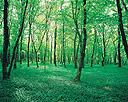

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[4.3414624e-13 8.7184399e-06 9.9997801e-01 1.2300786e-13 1.2235834e-06]]
sea , 
correct labels


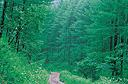

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[6.8602276e-05 4.6388353e-03 9.9006605e-01 5.2472977e-05 4.1607939e-04]]
sea , 
correct labels


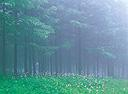

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[4.8852602e-17 1.7991538e-06 1.8640516e-09 7.1461291e-17 9.9999994e-01]]
trees , 
correct labels


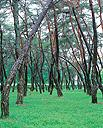

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[9.5581909e-06 1.0871368e-03 9.8649675e-01 4.2375799e-08 1.4398336e-04]]
sea , 
correct labels


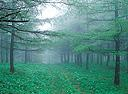

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.6259489e-30 6.1377859e-31 9.0260393e-33 1.4906244e-18 1.0000000e+00]]
trees , 
correct labels


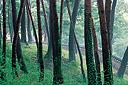

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.8306799e-21 2.7868360e-36 3.3705124e-08 2.6524815e-35 2.6014268e-02]]
trees
correct labels


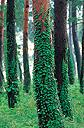

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[5.5992467e-05 2.8623721e-01 8.5967731e-01 1.6410491e-05 4.4695862e-05]]
sea , 
correct labels


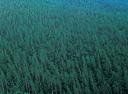

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[3.4260270e-19 6.0736031e-21 1.9416122e-08 1.6758568e-27 1.0000000e+00]]
trees , 
correct labels


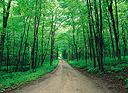

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.9932406e-06 1.2780218e-08 3.9814722e-06 3.8624182e-07 9.9994773e-01]]
trees , 
correct labels


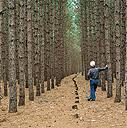

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[2.95970026e-09 1.31366642e-05 1.41368855e-05 7.09599014e-15
  9.99804676e-01]]
trees , 
correct labels


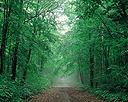

mountains
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[4.9527831e-21 1.0000000e+00 2.0567426e-01 7.7030084e-22 3.1246215e-03]]
mountains , 
correct labels


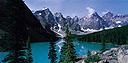

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[9.0071080e-05 5.6698970e-03 6.7726779e-01 1.7815076e-10 1.1187517e-02]]
sea
correct labels


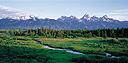

mountains
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.2149503e-13 1.0000000e+00 5.0882293e-12 1.1094253e-18 3.0773351e-06]]
mountains , 
correct labels


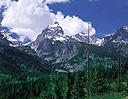

mountains
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.4102247e-13 9.9999994e-01 7.0569606e-10 1.8444832e-20 2.4740596e-04]]
mountains , 
correct labels


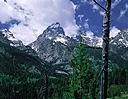

mountains
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[8.8130002e-07 9.7331631e-01 8.7599223e-03 2.5581573e-07 6.8682209e-02]]
mountains , 
correct labels


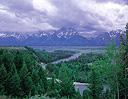

trees
1/1 [==============================] - 0s 35ms/step
predicted labels:: [[1.7635748e-26 3.0234922e-27 2.3528466e-21 1.4120196e-21 9.9999994e-01]]
trees , 
correct labels


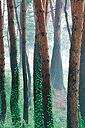

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[1.0673910e-35 3.3165270e-36 1.9481205e-25 1.7478411e-35 1.0000000e+00]]
trees , 
correct labels


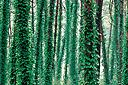

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[2.4624926e-03 3.3649011e-10 3.3036793e-07 6.8213274e-10 9.9689269e-01]]
trees , 
correct labels


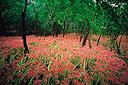

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[6.9386597e-06 7.7992915e-08 9.9999714e-01 1.7645481e-10 1.4515348e-01]]
sea , 
correct labels


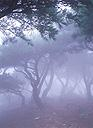

trees
1/1 [==============================] - 0s 35ms/step
predicted labels:: [[2.9077514e-13 6.8210136e-18 5.2537242e-08 6.4419194e-24 1.0000000e+00]]
trees , 
correct labels


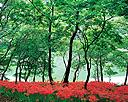

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.7243910e-01 3.2775668e-05 1.1955480e-06 3.3691736e-09 3.6288486e-04]]
desert
correct labels


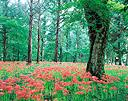

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[3.2995254e-12 2.9990273e-18 9.7605228e-01 2.3027806e-16 9.9900252e-01]]
sea , 
trees , 
correct labels


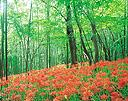

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[3.7545238e-27 6.2894303e-31 3.5620179e-10 6.2163822e-27 1.0000000e+00]]
trees , 
correct labels


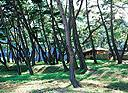

trees
1/1 [==============================] - 0s 29ms/step
predicted labels:: [[6.589039e-28 2.252295e-32 8.593990e-01 4.003116e-31 1.000000e+00]]
sea , 
trees , 
correct labels


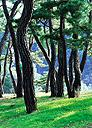

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[9.9650735e-01 6.8692439e-03 9.3876980e-03 2.2031585e-02 5.7328894e-04]]
desert , 
correct labels


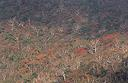

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[7.6342701e-09 8.5692143e-19 2.2228101e-02 2.6908079e-15 9.9998802e-01]]
trees , 
correct labels


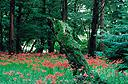

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[1.10133636e-13 4.29150682e-12 3.05470582e-02 4.76817375e-20
  9.99844790e-01]]
trees , 
correct labels


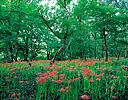

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[8.6147000e-28 1.5046073e-21 1.8062400e-08 2.9454362e-31 1.0000000e+00]]
trees , 
correct labels


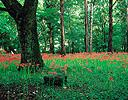

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[5.4759039e-05 3.9749821e-11 4.8579369e-07 2.4882407e-10 9.9931872e-01]]
trees , 
correct labels


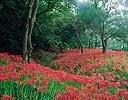

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[3.1712969e-11 4.2259677e-18 2.4852254e-09 7.0110496e-14 1.0000000e+00]]
trees , 
correct labels


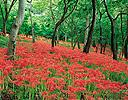

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[8.1549982e-11 3.4186452e-11 3.1111849e-12 6.4728074e-17 1.0000000e+00]]
trees , 
correct labels


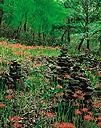

mountains
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[9.7554827e-01 3.4599573e-16 4.2372870e-09 1.9668666e-14 8.1305456e-01]]
desert , 
trees , 
correct labels


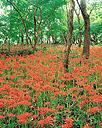

mountains
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.1390266e-05 3.1090689e-11 1.4312372e-12 4.3796158e-19 1.0000000e+00]]
trees , 
correct labels


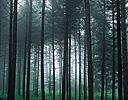

mountains
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[5.2893928e-10 3.2140443e-15 9.9999940e-01 2.0526334e-08 1.0372888e-21]]
sea , 
correct labels


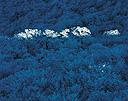

mountains
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[1.1564053e-24 5.7675809e-26 4.3891023e-25 7.4209822e-21 1.0000000e+00]]
trees , 
correct labels


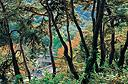

trees
1/1 [==============================] - 0s 36ms/step
predicted labels:: [[8.7114785e-24 2.4389932e-17 2.0726441e-29 6.5979629e-22 1.0000000e+00]]
trees , 
correct labels


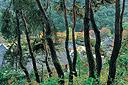

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[1.0532690e-23 3.1493999e-17 5.9082963e-34 1.7195149e-29 1.0000000e+00]]
trees , 
correct labels


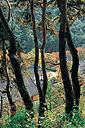

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[4.8472732e-05 2.1543384e-07 1.4048129e-03 3.0427658e-10 9.8429048e-01]]
trees , 
correct labels


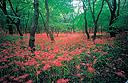

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[3.8985873e-04 1.5996536e-16 2.3152578e-12 5.5101822e-20 9.9999505e-01]]
trees , 
correct labels


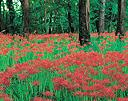

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[3.2093030e-15 8.8998565e-15 8.8999426e-11 1.1472762e-14 1.0000000e+00]]
trees , 
correct labels


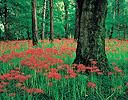

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[3.0477889e-04 2.2449263e-05 1.7999139e-02 2.6549779e-08 9.2495716e-01]]
trees , 
correct labels


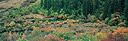

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[1.3349368e-02 1.1200376e-01 6.1193405e-04 6.4313112e-06 3.9970232e-03]]
mountains
correct labels


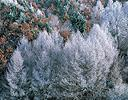

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[3.0352676e-05 1.3675491e-04 5.7275126e-11 1.4926901e-01 9.9878252e-01]]
trees , 
correct labels


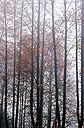

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[2.8919093e-03 3.4013933e-06 4.4716668e-05 3.0234576e-05 9.4546527e-01]]
trees , 
correct labels


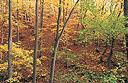

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[2.9659501e-01 1.6631348e-06 5.7360488e-08 1.4065788e-05 2.0637686e-05]]
desert
correct labels


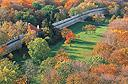

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[9.4742125e-01 7.0775227e-06 3.7745582e-03 1.6758962e-04 5.5731183e-01]]
desert , 
correct labels


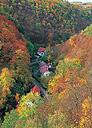

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[2.7800348e-10 9.1866965e-11 7.8676767e-06 7.4367421e-20 9.9979717e-01]]
trees , 
correct labels


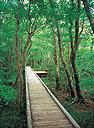

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.7409178e-12 8.0028235e-14 2.3498046e-06 9.9948487e-24 1.0000000e+00]]
trees , 
correct labels


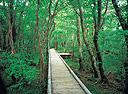

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[1.5043236e-13 9.9937487e-01 2.9353503e-06 2.5488778e-16 4.2808298e-02]]
mountains , 
correct labels


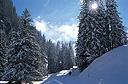

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[9.5722520e-01 1.0923350e-08 2.6479064e-04 8.4177786e-01 3.0577698e-06]]
desert , 
sunset , 
correct labels


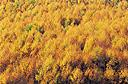

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[3.2775027e-01 7.9862694e-09 6.3181587e-02 9.9841791e-01 3.5549153e-08]]
sunset , 
correct labels


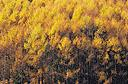

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.9137876e-01 5.8260921e-05 7.0625206e-04 4.4882214e-05 4.4553152e-01]]
trees
correct labels


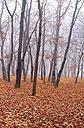

trees
1/1 [==============================] - 0s 37ms/step
predicted labels:: [[2.3763438e-10 1.5790778e-14 2.3104393e-07 6.5395529e-11 9.9999994e-01]]
trees , 
correct labels


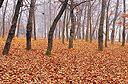

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[3.7127442e-04 3.0927495e-08 9.7634904e-02 1.8114231e-05 5.2138960e-01]]
trees
correct labels


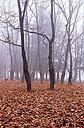

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[0.17907545 0.028101   0.19699012 0.00067699 0.5335373 ]]
trees
correct labels


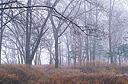

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[0.6404178  0.19087389 0.08487675 0.11688456 0.21433035]]
desert
correct labels


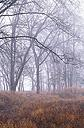

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.0241901e-02 3.6561036e-07 2.0506780e-03 3.2684903e-04 3.7425464e-01]]
trees
correct labels


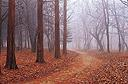

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.8089687e-10 2.4322945e-13 8.0874747e-01 2.3362512e-10 9.9999839e-01]]
sea , 
trees , 
correct labels


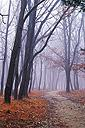

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[7.6330793e-01 4.2155331e-01 6.4680697e-03 4.6149961e-04 5.2898726e-03]]
desert , 
correct labels


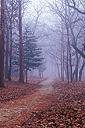

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.5750928e-02 8.4010011e-01 1.1922324e-06 2.7659325e-06 6.3206160e-01]]
mountains , 
correct labels


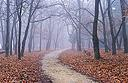

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[8.2907677e-03 8.8597280e-01 2.1356256e-03 2.7388245e-05 9.6923613e-04]]
mountains , 
correct labels


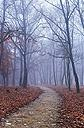

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[0.00447608 0.25112358 0.20324486 0.0002747  0.12320287]]
mountains
correct labels


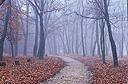

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[3.6086071e-01 1.7084947e-10 3.6808131e-05 2.5892419e-10 1.2256103e-01]]
desert
correct labels


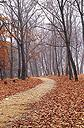

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[3.7280186e-06 3.5574860e-08 9.3357223e-12 1.4374871e-14 9.9913645e-01]]
trees , 
correct labels


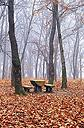

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[8.8080282e-10 7.9016715e-14 8.2356091e-06 1.4122134e-10 9.9999195e-01]]
trees , 
correct labels


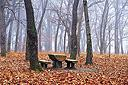

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[7.0868987e-01 6.7109889e-03 1.5284865e-08 7.4027789e-12 9.9997771e-01]]
desert , 
trees , 
correct labels


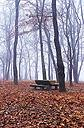

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[0.10403892 0.19555204 0.02086719 0.00407253 0.582218  ]]
trees
correct labels


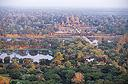

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[2.3625451e-03 2.2698336e-03 1.0055422e-04 5.9173005e-10 9.6159863e-01]]
trees , 
correct labels


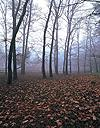

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[2.0387196e-08 1.2512521e-02 1.4740294e-06 1.0482016e-10 9.9999994e-01]]
trees , 
correct labels


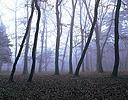

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[4.9522350e-07 4.7871990e-06 3.2441144e-10 3.3157738e-10 9.9996805e-01]]
trees , 
correct labels


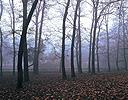

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[2.5012916e-01 9.9940138e-05 3.2810740e-02 4.0808581e-03 9.4010305e-01]]
trees , 
correct labels


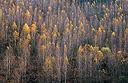

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[7.5745231e-01 1.3256118e-03 9.9724489e-01 2.5095058e-05 6.2209828e-04]]
desert , 
sea , 
correct labels


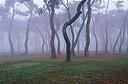

trees
1/1 [==============================] - 0s 36ms/step
predicted labels:: [[1.6621043e-09 1.0797175e-09 2.0001225e-01 5.4318241e-17 9.9999201e-01]]
trees , 
correct labels


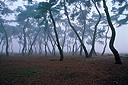

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.08733825e-01 2.31424975e-03 9.93478596e-01 1.44253398e-04
  6.36722543e-04]]
sea , 
correct labels


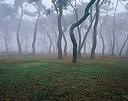

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[1.6220780e-03 4.1578710e-01 3.3324093e-05 4.8463948e-16 3.8152261e-04]]
mountains
correct labels


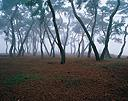

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[1.00793644e-04 9.60960097e-06 4.80747069e-08 8.16749110e-24
  7.23686635e-01]]
trees , 
correct labels


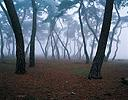

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[8.1679916e-16 9.7006154e-09 2.7141218e-07 3.2855030e-34 7.5334626e-01]]
trees , 
correct labels


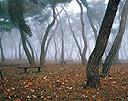

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.7927867e-01 4.3906752e-04 2.9517740e-02 3.4649684e-13 4.8671612e-03]]
desert
correct labels


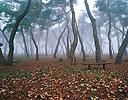

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[1.5631618e-03 7.0169240e-02 6.2189452e-02 6.0178775e-07 1.8463841e-02]]
mountains
correct labels


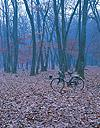

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[8.8875673e-13 1.5510128e-29 7.3732954e-06 1.8505572e-10 9.9999994e-01]]
trees , 
correct labels


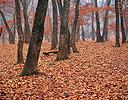

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[2.2955713e-16 6.2288050e-17 7.6166558e-13 3.1481221e-20 1.0000000e+00]]
trees , 
correct labels


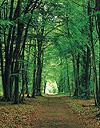

trees
1/1 [==============================] - 0s 30ms/step
predicted labels:: [[3.50209916e-07 4.54501569e-05 9.99938190e-01 5.03721065e-10
  1.07959544e-10]]
sea , 
correct labels


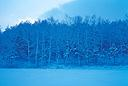

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[5.5649012e-17 9.9960995e-01 6.7726618e-01 2.8962927e-21 4.0058243e-10]]
mountains , 
correct labels


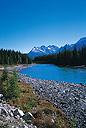

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[2.8594466e-16 9.9999827e-01 9.2402911e-01 1.4924387e-19 1.5184475e-11]]
mountains , 
sea , 
correct labels


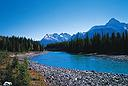

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[2.9708939e-16 1.0000000e+00 2.1006594e-17 2.0803675e-10 1.2255594e-12]]
mountains , 
correct labels


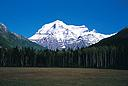

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[5.13663564e-15 1.65915395e-07 1.00000000e+00 1.07665101e-17
  1.09936045e-11]]
sea , 
correct labels


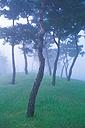

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[7.06108608e-07 1.26480827e-05 2.62288272e-01 9.82672886e-16
  1.24898314e-01]]
sea
correct labels


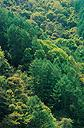

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[9.9980998e-01 1.0498941e-03 5.0609487e-14 2.7272041e-11 3.7887046e-05]]
desert , 
correct labels


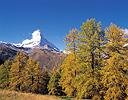

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[3.7591246e-06 7.3150381e-06 4.5919958e-01 3.6641540e-11 2.4629301e-01]]
sea
correct labels


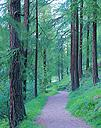

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[2.0358046e-04 1.3509038e-04 7.6740913e-02 2.3968438e-12 8.1460603e-06]]
sea
correct labels


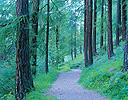

trees
1/1 [==============================] - 0s 35ms/step
predicted labels:: [[1.4218344e-11 3.2809348e-05 8.2851393e-08 3.6103954e-15 2.8628162e-01]]
trees
correct labels


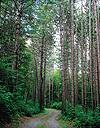

sea
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[1.0000000e+00 6.9480861e-09 7.8719269e-05 1.1070413e-04 3.7163144e-08]]
desert , 
correct labels


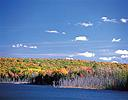

trees
1/1 [==============================] - 0s 32ms/step
predicted labels:: [[4.1137368e-06 6.6740724e-10 3.4324569e-07 1.2570945e-06 9.9993247e-01]]
trees , 
correct labels


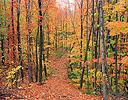

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[9.9999833e-01 2.8324230e-05 4.8836941e-06 2.8036386e-05 4.8474374e-04]]
desert , 
correct labels


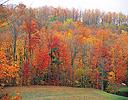

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[0.04690359 0.14393976 0.3032901  0.00084392 0.12462866]]
sea
correct labels


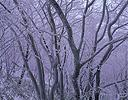

trees
1/1 [==============================] - 0s 34ms/step
predicted labels:: [[9.2985036e-05 4.6896082e-03 1.7752717e-04 3.0368881e-09 9.9988067e-01]]
trees , 
correct labels


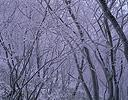

trees
1/1 [==============================] - 0s 33ms/step
predicted labels:: [[7.9863478e-04 5.0096548e-01 2.9274794e-01 2.0062171e-07 8.0414535e-04]]
mountains
correct labels


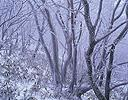

trees
1/1 [==============================] - 0s 31ms/step
predicted labels:: [[9.8589843e-04 6.1084674e-04 1.4975247e-07 6.7724341e-06 6.1121440e-01]]
trees
correct labels


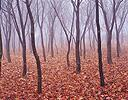

trees


In [90]:
#  test data outcomes
for i in range(1900,1999):
    predict_outcomes(f"/kaggle/input/miml-image-data/miml-image-data/original/{i}.jpg",model3)
    
    